# Course Project: An Arbitrage-Free Smile Interpolator
#### Written By: Jiang Shuang, Victor Kow, and Thomas Tai 
*Project report should be submitted as a Jupyter notebook (.ipynb). The report should be written based on this notebook. Please make your formulas and code, test results, observations, intermediate results, improvements made/suggested (optional), and conclusions clear.*

#### Objectives
  - Implement an arbitrage free smile interpolator SmileAF.
  - Use the arbitrage free smile interpolator to construct local volatility model
  - Use PDE with local volatility model to price a given set of European options (strike in delta $\times$ maturity)
  - Compare the price errors of arbitrage-free smile interpolator and the cubic spline smile interpolator

##### Smile Arbitrage
1. European call prices are monotonically decreasing with respect to the strike:

    \begin{align}
    C(S_0, K_1, T, \sigma(K_1), r, q) \geq C(S_0, K_2, T, \sigma(K_2), r, q) ~\text{for}~K_1 < K_2
    \end{align}


2. The European call price as a function of strike has to be convex every where: for any three points $K_1 < K_2 < K_3$

    \begin{align}
    \frac{C(K_2) - C(K_1) } {K_2 - K_1} < \frac{C(K_3) - C(K_2) } {K_3 - K_2}
    \end{align}

    or

    \begin{align}
    C(K_2)  < C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1}
    \end{align}

    This is also equivalent to "butterfly price has to be non-negative".

##### When Could Smile Arbitrage Happen?

The undiscounted call price is the expectation of payoff under risk neutral measure

\begin{align}
C(K) = E[\max(S-K, 0)]
\end{align}

And expectation is an integral over the probability density function $p(s)$

\begin{align}
C(K) = \int_{K}^{+\infty} (s-K) p(s) ds
\end{align}

The 1st non-arbitrage condition translates to

\begin{align}
& C(K_1) - C(K_2) = \left[ \int_{K_1}^{K_2} (s-K_1) p(s) ds  + \int_{K_2}^{+\infty} (K_2-K_1) p(s) ds \right]
\end{align}

which is positive by definition if $K_2 > K_1$.

The 2nd non-arbitrage condition translates to

\begin{align}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) \\
= & \frac{K_3-K_2} {K_3 - K_1} \int_{K_1}^{K_2} (s-K_1) p(s) ds + \frac{K_2 - K_1} {K_3 - K_1} \int_{K_2}^{K_3} (K_3 - s) p(s) ds
\end{align}

which is also positive by definition if $K_3 > K_2 > K_1$.

So, when could smile arbitrage happen? **When the probability density does not exist**. If we can start with valid probability density function $p(s)$, arbitrage-freeness is guaranteed by construction.


#### Arbitrage Free Smile (Based on [Fengler 2009])

- We consider smile construction for a given expiry $T$.
- Start with $N$ discrete sample strike points

    \begin{align*}
    \vec{k} = [k_1, k_2, \ldots, k_{N}]^{\top}
    \end{align*}

- Try to solve for undiscounted call prices for these $N$ sample points

    \begin{align*}
    \vec{c} = [c_1, c_2, \ldots, c_N]^{\top}
    \end{align*}

- For the undiscounted call price $C(K)$ for any $K$, we can interpolate using cubic spline over the sample points $(k_i, c_i)$. (Note that we are using cubic spline to interpolate the prices, not volatility)

- The second derivative of call price with respect to strike is the probability density function:

    \begin{align}
    \frac{d C}{d K} & =  d \frac{\int_K^{\infty} Sp(S) dS}{dK} - d \frac{K\int_K^{\infty} p(S) dS}{dK} = -Kp(K) - \left( \int_K^{\infty} p(S) dS - K p(K)\right) = -\int_K^{\infty} p(S) dS \\
    \frac{d^2 C}{d K^2} & = p(K)
    \end{align}

  So $c_i''$ is probability density function at $k_i$, we denote it as $p_i$

- Second derivatives in cubic spline interpolation form line segments. Cubic spline on $C(K)$, means linearly interpolate on probability density. If $p_i$ are all positive, the whole pdf is positive by construction --- **no smile arbitrage**.

- For tails --- call prices are almost linear if strike is very far away from spot, we can use **natural cubic spline**: $p_1 = p_N = 0$.

- Our problem is to solve for $[c_1, c_2, \ldots, c_{N}, p_2, \ldots, p_{N-1}]$

#### Inputs to our problem

Same as our Cubic Spline smile interpolator, we have the input marks to start with to construct the Arb-Free(AF) smile interpolator:

 - **Marks**:  strike to volatility pairs, denote as $(\hat k_j, \sigma_j)$, for $j \in [1, 2, \ldots, M]$. In our case, $M=5$.

We would like to match the marks exactly. And we cannot directly construct a cubic spline using the $M$ points --- too coarse and distribution is not realistic.

#### Problem Definition
- We use $N = 50$ sample points, ranging from $[k_1 = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T - 5 \sigma_{ATM} \sqrt{T}}, k_N = S e^{(r_d - r_f)T -\frac12\sigma_{ATM}^2T + 5 \sigma_{ATM} \sqrt{T} }]$, i.e., $\pm 5$ standard deviation based on $\sigma_{ATM}$.
- $\sigma_{ATM}$ is implied volatility of the middle point of the input marks.
- We also assume the strike of the middle point of the input marks is the forward --- ATM forward convention.
- The sample points are equally spaced, denote the length of the segment $u = \frac{k_N - k_1}{N-1}$
- We would like the call prices to be as smooth as possible --- minimize the change of the slopes
- We want to match exactly the $M$ input marks.
- This is a constrained optimization problem.

 **Constraints**
 - Cubic spline interpolation imposes the constraints that the left and right first derivative of a point have to match, it can be derived by matching the first  derivative of the left and right segments for point $i$ we have the condition

   \begin{align}
   c_{i+1} + c_{i-1} - 2 c_{i} = (\frac23 p_i + \frac16 p_{i+1} + \frac16 p_{i-1}) u^2
   \end{align}

   The cubic spline constraints translate to the linear system

   \begin{align} \underbrace{\begin{pmatrix}
   1 & -2 & 1 & 0 & \ldots & 0 \\
   0 & 1 & -2 & 1 & \ddots & \vdots \\
   \vdots & \ddots & \ddots & \ddots & \ddots & 0 \\
   0 & \ldots & 0 & 1 & -2 & 1
   \end{pmatrix}}_{\vec{Q}_{(N-2) \times N}}
   \begin{pmatrix}
   c_1 \\
   c_2 \\
   \vdots \\
   c_N
   \end{pmatrix} =
   \underbrace{u^2
   \begin{pmatrix}
   \frac23 & \frac16 & 0 & \ldots & 0 \\
   \frac16 & \frac23 & \frac16 & \ddots & \vdots \\
   0 & \ddots & \ddots & \ddots & 0 \\
   \vdots & \ddots & \frac 1 6 & \frac23 & \frac16 \\
   0 & \ldots & 0 & \frac 1 6 &  \frac23
   \end{pmatrix}}_{\vec{R}_{(N-2) \times (N-2)}}
   \begin{pmatrix}
   p_2 \\
   p_3 \\
   \vdots \\
   p_{N-1}
   \end{pmatrix}
   \end{align}

   If we define
   \begin{align}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
   \end{align}

   we can represent the constraint as:
   \begin{align}
   \vec{Ax} = \vec{0}        ~~~\textbf{--- Constraint 1}
   \end{align}

 - The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
   \begin{align}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1}
   ~~~\textbf{--- Constraint 2}
   \end{align}

   where

   \begin{align}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
   \end{align}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

 - $p_i$ are densities, so

    \begin{align}
    p_i > 0 ~~~\textbf{--- Constraint 3}
    \end{align}

 - Integrating the density function we should get 1.0 (recall that density function are linearly interpolated)

    \begin{align}
    u \sum p_i = 1.0 ~~~\textbf{--- Constraint 4}
    \end{align}

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align}

 - Call prices are monotonically decreasing:

    \begin{align}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align}


 **Objective Function**

 - Fill the rest of the DOF using objective function (soft constraints)

 - [Fengler 2009] tried minimizing the below to achieve smoothness on $p$:

    \begin{align}
    \int_{k_1}^{k_N} p(S)^2 dS = \text{constant} \times \vec{p}^{\top} \vec{R} \vec{p}
    \end{align}

    Using $\vec{x}$ as variable and define

    \begin{align}
    \vec{H}_{(2N-2) \times (2N-2)} =
    \begin{pmatrix}
    \vec{0} & \vec{0} \\
    \vec{0} & \vec{R}_{(N-2) \times (N-2)}
    \end{pmatrix}
    \end{align}

    the problem becomes minimizing

    \begin{align}
    \vec{x}^\top \vec{H} \vec{x}
    \end{align}

**Problem Formulation**

 We can formulate our problem as
    \begin{align}
    \min~~~\vec{x}^\top \vec{H} \vec{x}
    \end{align}
 subject to constraints 1 to 5.
 - All the constraints are linear function of $\vec{x}$
 - Our objective function is quadratic and the matrix $\vec{H}$ is positive semi-definite
 - Global solution exists, and (relatively) efficient to solve

**Tips**
 - To solve the quadratic programming problem, we can use the CVXOPT package:
   - http://cvxopt.org/examples/tutorial/qp.html
   - https://courses.csail.mit.edu/6.867/wiki/images/a/a7/Qp-cvxopt.pdf
 - Write down the exact formulas using the same symbols used by CVXOPT QP problem's documentation in the above docs, then translate them into code. This will make debugging easier.
 - To check whether solver's result makes sense, examine if the constraints are satisified, and if the call prices are smooth and match the input.
 - If test run takes too long, reduce the number of grid points in PDE pricer, or skip the calibration report and inspect the volatility surface first.
 - It might be easier to plot implied vol, call prices, PDF, and the marks to check the result.
 - use bisect.bisect_left to find the bucket $\hat{k}$ belongs to (https://docs.python.org/3/library/bisect.html)

**References**

[Fengler 2009] Arbitrage-free smoothing of the implied volatility surface, Quantitative Finance, 2009

***
### Implementation

Below are some building blocks for the project. You contribution should be in SmileAF class.
You can modify any other classes or methods. If you do so, please describe your modification in the project report.

In [2]:
import math
from enum import Enum
from scipy import optimize
import bisect
from scipy.interpolate import CubicSpline
import numpy as np
from cvxopt import matrix, solvers


class PayoffType(Enum):
    Call = 0
    Put = 1

def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def fwdDelta(fwd, stdev, strike, payoffType):
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    if payoffType == PayoffType.Call:
        return cnorm(d1)
    elif payoffType == PayoffType.Put:
        return - cnorm(-d1)
    else:
        raise Exception("not supported payoff type", payoffType)

# solve for the K such that Delta(S, T, K, vol) = delta
def strikeFromDelta(S, r, q, T, vol, delta, payoffType):
    fwd = S * math.exp((r-q) * T)
    if payoffType == PayoffType.Put:
        delta = -delta
    f = lambda K: (fwdDelta(fwd, vol * math.sqrt(T), K, payoffType) - delta)
    a, b = 0.0001, 10000
    return optimize.brentq(f, a, b)

class ImpliedVol:
    def __init__(self, ts, smiles):
        self.ts = ts
        self.smiles = smiles
    # linear interpolation in variance, along the strike line
    def Vol(self, t, k):
        # locate the interval t is in
        pos = bisect.bisect_left(self.ts, t)
        # if t is on or in front of first pillar,
        if pos == 0:
            return self.smiles[0].Vol(k)
        if pos >= len(self.ts):
            return self.smiles[-1].Vol(k)
        else:  # in between two brackets
            prevVol, prevT = self.smiles[pos-1].Vol(k), self.ts[pos-1]
            nextVol, nextT = self.smiles[pos].Vol(k), self.ts[pos]
            w = (nextT - t) / (nextT - prevT)
            prevVar = prevVol * prevVol * prevT
            nextVar = nextVol * nextVol * nextT
            return  math.sqrt((w * prevVar + (1-w) * nextVar)/t)
        return

    def dVoldK(self, t, k):
        return (self.Vol(t, k+0.001) - self.Vol(t, k-0.001)) / 0.002
    def dVoldT(self, t, k):
        return (self.Vol(t+0.005, k) - self.Vol(t, k)) / 0.005
    def dVol2dK2(self, t, k):
        return (self.Vol(t, k+0.001) + self.Vol(t, k-0.001) - 2*self.Vol(t, k)) / 0.000001

class LocalVol:
    def __init__(self, iv, S0, rd, rf):
        self.iv = iv
        self.S0 = S0
        self.rd = rd
        self.rf = rf
    def LV(self, t, s):
        if t < 1e-6:
            return self.iv.Vol(t, s)
        imp = self.iv.Vol(t, s)
        dvdk = self.iv.dVoldK(t, s)
        dvdt = self.iv.dVoldT(t, s)
        d2vdk2 = self.iv.dVol2dK2(t, s)
        d1 = (math.log(self.S0/s) + (self.rd-self.rf)*t + imp * imp * t / 2) / imp / math.sqrt(t)
        numerator = imp*imp + 2*t*imp*dvdt + 2*(self.rd-self.rf)*s*t*imp*dvdk
        denominator = (1+s*d1*math.sqrt(t)*dvdk)**2 + s*s*t*imp*(d2vdk2 - d1 * math.sqrt(t) * dvdk * dvdk)
        localvar = min(max(numerator / denominator, 1e-8), 1.0)
        if numerator < 0: # floor local volatility
            localvar = 1e-8
        if denominator < 0: # cap local volatility
            localvar = 1.0
        return math.sqrt(localvar)

class EuropeanOption():
    def __init__(self, assetName, expiry, strike, payoffType):
        self.assetName = assetName
        self.expiry = expiry
        self.strike = strike
        self.payoffType = payoffType
    def payoff(self, S):
        if self.payoffType == PayoffType.Call:
            return max(S - self.strike, 0)
        elif self.payoffType == PayoffType.Put:
            return max(self.strike - S, 0)
        else:
            raise Exception("payoffType not supported: ", self.payoffType)
    def valueAtNode(self, t, S, continuation):
        if continuation == None:
            return self.payoff(S)
        else:
            return continuation

# Black-Scholes analytic pricer
def bsPrice(S, r, q, vol, T, strike, payoffType):
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return math.exp(-r * T) * (fwd * cnorm(d1) - cnorm(d2) * strike)
    elif payoffType == PayoffType.Put:
        return math.exp(-r * T) * (strike * cnorm(-d2) - cnorm(-d1) * fwd)
    else:
        raise Exception("not supported payoff type", payoffType)

# PDE pricer with local volatility
def pdePricerX(S0, r, q, lv, NX, NT, w, trade):
    # set up pde grid
    mu = r - q
    T = trade.expiry
    X0 = math.log(S0)
    vol0 = lv.LV(0, S0)
    srange = 5 * vol0 * math.sqrt(T)
    maxX = X0 + (mu - vol0 * vol0 * 0.5)*T + srange
    minX = X0 - (mu - vol0 * vol0 * 0.5)*T - srange
    dt = T / (NT-1)
    dx = (maxX - minX) / (NX-1)
    # set up spot grid
    xGrid = np.array([minX + i*dx for i in range(NX)])
    # initialize the payoff
    ps = np.array([trade.payoff(math.exp(x)) for x in xGrid])
    # backward induction
    for j in range(1, NT):
        # set up the matrix, for LV we need to update it for each iteration
        M = np.zeros((NX, NX))
        D = np.zeros((NX, NX))
        for i in range(1, NX - 1):
            vol = lv.LV(j*dt, math.exp(xGrid[i]))
            M[i, i - 1] = (mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            M[i, i] = r + vol * vol / dx / dx
            M[i, i + 1] = -(mu - vol * vol / 2.0) / 2.0 / dx - vol * vol / 2 / dx / dx
            D[i, i] = 1.0
        # the first row and last row depends on the boundary condition
        M[0, 0], M[NX - 1, NX - 1] = 1.0, 1.0
        rhsM = (D - dt * M) * w + (1 - w) * np.identity(NX)
        lhsM = w * np.identity(NX) + (D + dt * M) * (1 - w)
        inv = np.linalg.inv(lhsM)

        ps = rhsM.dot(ps)
        ps[0] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[0])) # discounted payoff
        ps[NX-1] = dt*math.exp(-r*j*dt) * trade.payoff(math.exp(xGrid[NX-1]))
        ps = inv.dot(ps)
    # linear interpolate the price at S0
    return np.interp(X0, xGrid, ps)

def undiscounted_bsPrice(S, r, q, vol, T, strike, payoffType):
    fwd = S * math.exp((r-q) * T)
    stdev = vol * math.sqrt(T)
    d1 = math.log(fwd / strike) / stdev + stdev / 2
    d2 = d1 - stdev
    if payoffType == PayoffType.Call:
        return fwd * cnorm(d1) - cnorm(d2) * strike
    elif payoffType == PayoffType.Put:
        return strike * cnorm(-d2) - cnorm(-d1) * fwd
    else:
        raise Exception("not supported payoff type", payoffType)

Below are the smile interpolators and smile constructor. You need to implement SmileAF. Note that smileFromMarks takes a parameter smileInterpMethod. When it is 'AF', SmileAF is used.

In [3]:
class SmileAF:
    def __init__(self, strikes, vols, T,r,q0):
        self.atmvol = vols[int(len(vols)/2)]
        self.fwd = strikes[int(len(strikes)/2)]
        self.T = T
        self.N = 50
        stdev = self.atmvol * math.sqrt(T)
        kmin = self.fwd * math.exp(-0.5*stdev*stdev-5 * stdev)
        kmax = self.fwd * math.exp(-0.5*stdev*stdev+5 * stdev)
        u = (kmax - kmin) / (self.N - 1)
        self.ks = [kmin + u * i for i in range(0, self.N)]
        self.cs = np.zeros(self.N)  # undiscounted call option prices
        self.ps = np.zeros(self.N)  # densities
        self.u = u
        self.vols=vols
        self.strikes=strikes
        
        # now we need to construct our constrained optimization problem to solve for cs and ps
        # ... YOUR CODE HERE ... to solve for self.cs and self.ps
        # ...
    
        #Constrain1
        Q=[]
        for i in range(self.N-2):
            a=np.zeros(self.N)
            a[i],a[i+1],a[i+2]=1,-2,1
            Q.append(a)
    
        R=[]
        R_=[]
        for i in range(self.N-2):
            a=np.zeros(self.N-1)
            a[i-1],a[i],a[i+1]=1/6 ,2/3,1/6
            a=a[0:-1]
            R.append(a*u**2)
            R_.append(-a*u**2)
        C_1=np.hstack([Q,R_])
        b_1=np.zeros((self.N-2,1))
        
        #Constrain2
        C_2=[]
        for i in self.strikes:
            pos = bisect.bisect_left(self.ks, i)
            a = (self.ks[pos] - i) / self.u
            b = 1 - a
            c = (a * a * a - a) * self.u * self.u / 6.0
            d = (b * b * b - b) * self.u * self.u / 6.0
            aa=np.zeros(2*self.N-2)
            aa[pos-1],aa[pos],aa[self.N+pos-1],aa[self.N+pos]=a,b,c,d
            C_2.append(aa)
            
        C_k=[undiscounted_bsPrice(S,r,q0,vols[i],T,strikes[i],PayoffType.Call) for i in range(5)]
        b_2=np.array(C_k).reshape(5,1)
        
        #Constrain4
        C_4=np.hstack([np.zeros((1,self.N)),self.u*np.ones((1,self.N-2))])
        b_4=np.ones((1,1))
        
            
        #Constrain5
        C_5=[]
        a=np.zeros(2*self.N-2)
        a[0]=1
        C_5.append(a)
        b=np.zeros(2*self.N-2)
        b[self.N-1]=1
        C_5=np.vstack([a,b])
        b_5=np.ones((2,1))
        b_5[0,0]=self.fwd-kmin
        b_5[1,0]=0
        
        
        
        #Constrain3
        C_3=[]
        for i in range (self.N,2*self.N-2):
            a=np.zeros(2*self.N-2)
            a[i]=-1
            C_3.append(a)
        h_3=np.zeros((self.N-2,1))
        

        
        #Constrain6
        C_6=[]
        for i in range(self.N-1):
            a=np.zeros(2*self.N-2)
            a[i]=-1
            a[i+1]=1
            C_6.append(a)
        h_6=np.zeros((self.N-1,1))
        
        
       ##H 
        H=np.vstack([np.zeros((self.N,2*self.N-2)),np.hstack([np.zeros((self.N-2,self.N)),R])])
        
        P=2*matrix(H,tc='d')
        q=matrix(np.zeros((2*self.N-2,1)),tc='d')
        A=matrix(np.vstack([C_1,C_2,C_4,C_5]),tc='d')
        b=matrix(np.vstack([b_1,b_2,b_4,b_5]),tc='d')
        G=matrix(np.vstack([C_3,C_6]),tc='d')
        h=matrix(np.vstack([h_3,h_6]),tc='d')
        
        sol = solvers.qp(P,q,G,h,A,b)
        x=sol["x"]
        self.cs = x[:self.N]
        self.ps[1:self.N-1] = list(x)[self.N:]
        print(self.ps)
        print(self.u*np.sum(self.ps))
        
        
        

        # now we obtained cs and ps, we do not interpolate for price for any k and imply the vol,
        # since at the tails the price to vol gradient is too low and is numerically not stable.
        # Instead, we imply the volatilities for all points between put 10 delta and call 10 delta input points
        # then we make the vol flat at the wings by setting the vols at kmin and kmax,
        # we then construct a cubic spline interpolator on the dense set of volatilities so that it's C2
        # and faster then implying volatilities on the fly.
        # note that this treatment of tail is simplified. It could also introduce arbitrage.
        # In practice, the tails should be calibrated to a certain distribution.
        def implyVol(k, prc, v):
            stdev = v * math.sqrt(self.T)
            d1 = (math.log(self.fwd / k)) / stdev + 0.5 * stdev
            d2 = (math.log(self.fwd / k)) / stdev - 0.5 * stdev
            return self.fwd * cnorm(d1) - k * cnorm(d2) - prc
        
        khmin = bisect.bisect_left(self.ks, strikes[0])
        khmax = bisect.bisect_right(self.ks, strikes[len(strikes)-1])
        kks = [0] * ((khmax+1) - (khmin-1) + 2)
        vs = [0] * ((khmax+1) - (khmin-1) + 2)
        for i in range(khmin-1, khmax+1):
            prc = self.Price(self.ks[i])
            f = lambda v: implyVol(self.ks[i], prc, v)
            a, b = 1e-8, 10
            vs[i - (khmin-1) + 1] = optimize.brentq(f, a, b)
            kks[i - (khmin-1) + 1] = self.ks[i]
        kks[0] = kmin
        vs[0] = vs[1]
        kks[len(kks)-1] = kmax
        vs[len(vs)-1] = vs[len(vs)-2]

        self.vs = vs
        self.cubicVol = CubicSpline(kks, vs, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        if k < self.ks[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vs[0]
        if k > self.ks[-1]:
            return self.vs[-1]
        else:
            return self.cubicVol(k)

    # undiscounted call price - given cs and ps,
    # we can obtain undiscounted call price for any k via cubic spline interpolation
    def Price(self, k):
        if k <= self.ks[0]:
            return self.fwd - k
        if k >= self.ks[self.N-1]:
            return 0.0
        pos = bisect.bisect_left(self.ks, k)
        a = (self.ks[pos] - k) / self.u
        b = 1 - a
        c = (a * a * a - a) * self.u * self.u / 6.0
        d = (b * b * b - b) * self.u * self.u / 6.0
        return a * self.cs[pos-1] + b * self.cs[pos] + c*self.ps[pos-1] + d*self.ps[pos]
        
class SmileCubicSpline:
    def __init__(self, strikes, vols):
        # add additional point on the right to avoid arbitrage
        self.strikes = strikes + [1.1 * strikes[-1] - 0.1 * strikes[-2]]
        self.vols = vols + [vols[-1] + (vols[-1] - vols[-2]) / 10]
        self.cs = CubicSpline(strikes, vols, bc_type=((1, 0.0), (1, 0.0)), extrapolate=True)

    def Vol(self, k):
        if k < self.strikes[0]:  # scipy cubicspline bc_type confusing, extrapolate by ourselfs
            return self.vols[0]
        if k > self.strikes[-1]:
            return self.vols[-1]
        else:
            return self.cs(k)

def smileFromMarks(T, S, r, q, atmvol, bf25, rr25, bf10, rr10, smileInterpMethod):
    c25 = bf25 + atmvol + rr25/2
    p25 = bf25 + atmvol - rr25/2
    c10 = bf10 + atmvol + rr10/2
    p10 = bf10 + atmvol - rr10/2

    ks = [ strikeFromDelta(S, r, q, T, p10, 0.1, PayoffType.Put),
           strikeFromDelta(S, r, q, T, p25, 0.25, PayoffType.Put),
           S * math.exp((r-q)*T),
           strikeFromDelta(S, r, q, T, c25, 0.25, PayoffType.Call),
           strikeFromDelta(S, r, q, T, c10, 0.1, PayoffType.Call) ]
    # print(T, ks)
    if smileInterpMethod == "CUBICSPLINE":
        return SmileCubicSpline(ks, [p10, p25, atmvol, c25, c10])
    elif smileInterpMethod == "AF":
        return SmileAF(ks, [p10, p25, atmvol, c25, c10], T,r,q)

In [4]:
def createTestImpliedVol(S, r, q, sc, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i]*sc, rr25s[i]*sc, bf10s[i]*sc, rr10s[i]*sc, smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

Below is a calibration report that shows the calibration error of local volatility PDE pricer.

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def createTestFlatVol(S, r, q, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = np.zeros(len(atmvols))
    rr25s = np.zeros(len(atmvols))
    bf10s = np.zeros(len(atmvols))
    rr10s = np.zeros(len(atmvols))
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i], smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def createTestImpliedVol(S, r, q, sc, smileInterpMethod):
    pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
    atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
    bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
    rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
    bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
    rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]
    smiles = [smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i]*sc, rr25s[i]*sc, bf10s[i]*sc, rr10s[i]*sc, smileInterpMethod) for i in range(len(pillars))]
    return ImpliedVol(pillars, smiles)

def plotTestImpliedVolSurface(iv):
    tStart, tEnd = 0.02, 5
    ts = np.arange(tStart, tEnd, 0.1)
    fwdEnd = S*math.exp((r-q)*tEnd)
    kmin = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Put)
    kmax = strikeFromDelta(S, r, q, tEnd, iv.Vol(tEnd, fwdEnd), 0.1, PayoffType.Call)
    ks = np.arange(kmin, kmax, 0.01)
    vs = np.ndarray((len(ts), len(ks)))
    lv = LocalVol(iv, S, r, q)
    lvs = np.ndarray((len(ts), len(ks)))
    for i in range(len(ts)):
        for j in range(len(ks)):
            vs[i, j] = iv.Vol(ts[i], ks[j])
            lvs[i, j] = lv.LV(ts[i], ks[j])
    hf = plt.figure(figsize=(8, 6), dpi=80)
    ha = hf.add_subplot(121, projection='3d')
    hb = hf.add_subplot(122, projection='3d')
    X, Y = np.meshgrid(ks, ts)
    ha.plot_surface(X, Y, vs)
    ha.set_title("implied vol")
    ha.set_xlabel("strike")
    ha.set_ylabel("T")
    hb.plot_surface(X, Y, lvs)
    hb.set_title("local vol")
    hb.set_xlabel("strike")
    hb.set_ylabel("T")
    plt.show()

# the PDE calibration error report takes a implied volatility surface,
# verifies the pricing error of the pde pricer with local volatility surface
def pdeCalibReport(S0, r, q, impliedVol):
    ts = [0.02, 0.04, 0.06, 1/12.0, 1/6.0, 1/4.0, 1/2.0, 1, 2, 5]
    ds = np.arange(0.1, 1.0, 0.1)
    # ds = np.arange(0.5, 1.7, 0.1)
    err = np.zeros((len(ds), len(ts)))
    fig, ax = plt.subplots()

    ax.set_xticks(np.arange(len(ts)))
    ax.set_xlabel("T")
    ax.set_yticks(np.arange(len(ds)))
    ax.set_ylabel("Put Delta")
    ax.set_xticklabels(map(lambda t : round(t, 2), ts))
    ax.set_yticklabels(map(lambda d : round(d, 1), ds))

    # create local vol surface
    lv = LocalVol(impliedVol, S0, r, q)
    # Loop over data dimensions and create text annotations.
    for i in range(len(ds)):
        for j in range(len(ts)):
            T = ts[j]
            K = strikeFromDelta(S0, r, 0, T, iv.Vol(T, S0*math.exp(r*T)), ds[i], PayoffType.Put)
            payoff = PayoffType.Put
            trade = EuropeanOption("ASSET1", T, K, payoff)
            vol = impliedVol.Vol(ts[j], K)
            bs = bsPrice(S0, r, q, vol, T, K, payoff)
            pde = pdePricerX(S0, r, q, lv, max(50, int(50 * T)), max(50, int(50 * T)), 0.5, trade)
            # normalize error in 1 basis point per 1 unit of stock
            err[i, j] = math.fabs(bs - pde)/S0 * 10000
            ax.text(j, i, round(err[i, j], 1), ha="center", va="center", color="w")
    im = ax.imshow(err)
    ax.set_title("Dupire Calibration PV Error Matrix")
    fig.tight_layout()
    plt.show()

In [6]:
S, r, q = 1.25805, 0.01, 0.0
createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF')

     pcost       dcost       gap    pres   dres
 0:  5.7246e-02 -1.0573e+03  4e+03  2e+01  1e+02
 1:  5.7950e-02 -1.6440e+02  3e+02  1e+00  7e+00
 2:  6.0016e-02 -2.2449e+01  2e+01  1e-02  7e-02
 3:  6.0008e-02 -5.5032e-01  6e-01  3e-04  1e-03
 4:  5.9564e-02 -1.2300e-01  2e-01  6e-05  3e-04
 5:  5.9036e-02  3.5482e-02  2e-02  7e-06  4e-05
 6:  5.8504e-02  5.5138e-02  3e-03  8e-07  4e-06
 7:  5.8186e-02  5.7599e-02  6e-04  9e-08  5e-07
 8:  5.8062e-02  5.7949e-02  1e-04  1e-08  7e-08
 9:  5.8025e-02  5.8012e-02  1e-05  1e-09  6e-09
10:  5.8019e-02  5.8019e-02  4e-07  2e-11  1e-10
11:  5.8019e-02  5.8019e-02  4e-09  2e-13  1e-12
Optimal solution found.
[0.00000000e+00 8.35910048e-08 9.19256706e-08 1.06811020e-07
 1.35728491e-07 1.94299628e-07 3.23446162e-07 6.80105677e-07
 2.88320719e-06 2.16007010e-04 5.99736334e-01 1.18125504e+00
 1.76776568e+00 2.35230924e+00 2.93973016e+00 3.51760846e+00
 4.13078000e+00 5.09051422e+00 7.11080845e+00 9.32393758e+00
 1.12873410e+01 1.27210744e+01 1.41

 1:  7.3475e-02 -1.2346e+01  2e+01  3e-01  5e-01
 2:  7.3995e-02 -1.7249e+00  2e+00  2e-02  4e-02
 3:  7.3620e-02 -7.5887e-01  1e+00  1e-02  2e-02
 4:  7.7134e-02 -3.4932e-01  5e-01  1e-03  2e-03
 5:  7.6893e-02  4.1443e-02  4e-02  6e-05  1e-04
 6:  7.4967e-02  6.0089e-02  1e-02  1e-15  2e-14
 7:  7.4707e-02  6.9441e-02  5e-03  4e-16  7e-15
 8:  7.4055e-02  7.2165e-02  2e-03  4e-16  3e-15
 9:  7.3813e-02  7.3361e-02  5e-04  9e-16  2e-15
10:  7.3698e-02  7.3565e-02  1e-04  7e-16  2e-15
11:  7.3656e-02  7.3640e-02  2e-05  9e-16  2e-15
12:  7.3650e-02  7.3649e-02  4e-07  6e-16  1e-15
13:  7.3649e-02  7.3649e-02  4e-09  5e-16  1e-15
Optimal solution found.
[0.00000000e+00 1.26457018e-01 1.57520497e-01 2.14145276e-01
 2.63918391e-01 3.15536878e-01 3.66625543e-01 4.17988132e-01
 5.16852336e-01 6.17627731e-01 7.31495249e-01 1.21187573e+00
 1.68272750e+00 1.76588257e+00 1.49071417e+00 1.17404032e+00
 9.23457881e-01 6.38957157e-01 3.65209864e-01 2.42801876e-01
 2.07520121e-01 1.76305053e-01 1.2

We test with no smile case first. In the calibration error report, we are showing the error in basis points -- 0.01% with respect to 1 notional.

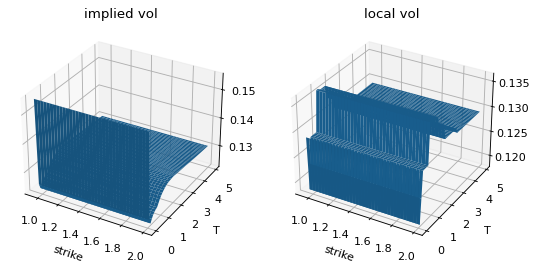

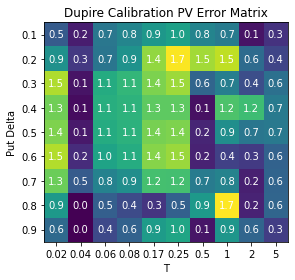

In [7]:
S, r, q = 1.25805, 0.01, 0.0
iv = createTestImpliedVol(S, r, q, sc = 0.0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a mild smile (tuned by the coeffiicent sc)

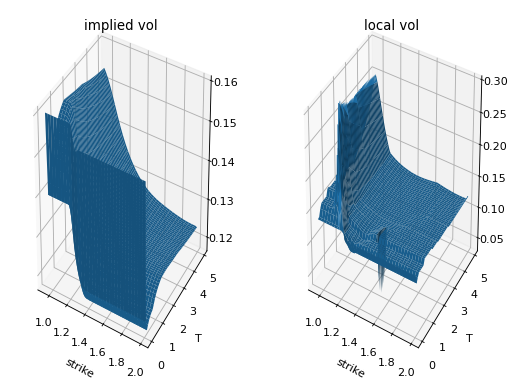

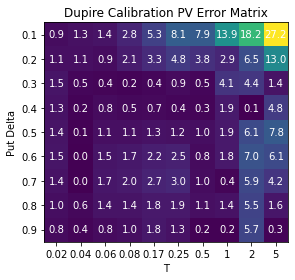

In [7]:
iv = createTestImpliedVol(S, r, q, sc = 0.5, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

Then test smile case with CubicSpline, with a the input smile (sc = 1.0). It can be seen that the short end low strike region has some smile arbitrage. The calibration errors become larger.

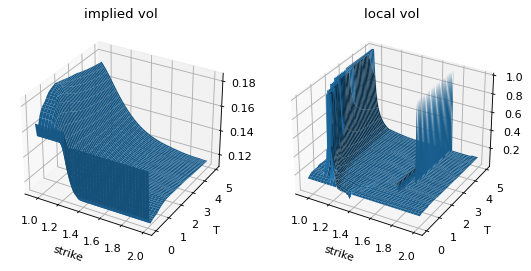

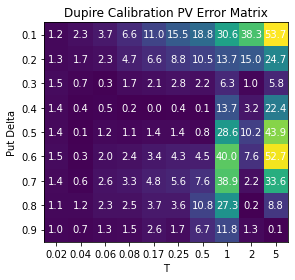

In [8]:
iv_cubic = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='CUBICSPLINE')
plotTestImpliedVolSurface(iv_cubic)
pdeCalibReport(S, r, q, iv_cubic)

***
### Your test cases with SmileAF

     pcost       dcost       gap    pres   dres
 0:  5.7246e-02 -1.0573e+03  4e+03  2e+01  1e+02
 1:  5.7950e-02 -1.6440e+02  3e+02  1e+00  7e+00
 2:  6.0016e-02 -2.2449e+01  2e+01  1e-02  7e-02
 3:  6.0008e-02 -5.5032e-01  6e-01  3e-04  1e-03
 4:  5.9564e-02 -1.2300e-01  2e-01  6e-05  3e-04
 5:  5.9036e-02  3.5482e-02  2e-02  7e-06  4e-05
 6:  5.8504e-02  5.5138e-02  3e-03  8e-07  4e-06
 7:  5.8186e-02  5.7599e-02  6e-04  9e-08  5e-07
 8:  5.8062e-02  5.7949e-02  1e-04  1e-08  7e-08
 9:  5.8025e-02  5.8012e-02  1e-05  1e-09  6e-09
10:  5.8019e-02  5.8019e-02  4e-07  2e-11  1e-10
11:  5.8019e-02  5.8019e-02  4e-09  2e-13  1e-12
Optimal solution found.
[0.00000000e+00 8.35910048e-08 9.19256706e-08 1.06811020e-07
 1.35728491e-07 1.94299628e-07 3.23446162e-07 6.80105677e-07
 2.88320719e-06 2.16007010e-04 5.99736334e-01 1.18125504e+00
 1.76776568e+00 2.35230924e+00 2.93973016e+00 3.51760846e+00
 4.13078000e+00 5.09051422e+00 7.11080845e+00 9.32393758e+00
 1.12873410e+01 1.27210744e+01 1.41

 5:  7.6893e-02  4.1443e-02  4e-02  6e-05  1e-04
 6:  7.4967e-02  6.0089e-02  1e-02  1e-15  2e-14
 7:  7.4707e-02  6.9441e-02  5e-03  4e-16  7e-15
 8:  7.4055e-02  7.2165e-02  2e-03  4e-16  3e-15
 9:  7.3813e-02  7.3361e-02  5e-04  9e-16  2e-15
10:  7.3698e-02  7.3565e-02  1e-04  7e-16  2e-15
11:  7.3656e-02  7.3640e-02  2e-05  9e-16  2e-15
12:  7.3650e-02  7.3649e-02  4e-07  6e-16  1e-15
13:  7.3649e-02  7.3649e-02  4e-09  5e-16  1e-15
Optimal solution found.
[0.00000000e+00 1.26457018e-01 1.57520497e-01 2.14145276e-01
 2.63918391e-01 3.15536878e-01 3.66625543e-01 4.17988132e-01
 5.16852336e-01 6.17627731e-01 7.31495249e-01 1.21187573e+00
 1.68272750e+00 1.76588257e+00 1.49071417e+00 1.17404032e+00
 9.23457881e-01 6.38957157e-01 3.65209864e-01 2.42801876e-01
 2.07520121e-01 1.76305053e-01 1.29674986e-01 8.71501249e-02
 4.36199767e-02 9.65838763e-06 1.85404091e-07 5.64073156e-08
 3.42878730e-08 2.52458028e-08 2.02950752e-08 1.71553189e-08
 1.49841175e-08 1.33969440e-08 1.21927045e-08 1

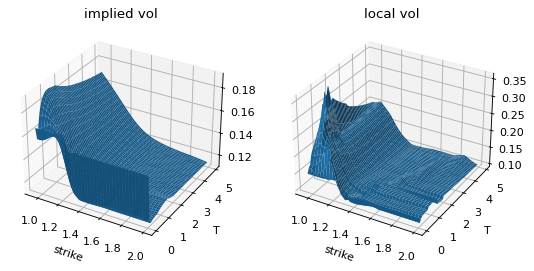

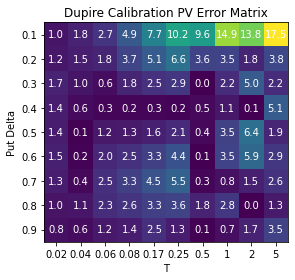

In [9]:
iv = createTestImpliedVol(S, r, q, sc = 1.0, smileInterpMethod='AF')
plotTestImpliedVolSurface(iv)
pdeCalibReport(S, r, q, iv)

### Further Debug and Explanations

We attempt to further understand the behaviour of the volatility surfaces, by first checking if the arbitrage conditions are satistifed. 

Recall, we require the following two conditions for the surface to be arbitrage free, for undiscounted call prices $C(\space)$:

The 1st non-arbitrage condition states that for $K_2 > K_1$,

\begin{align}
& C(K_1) - C(K_2) > 0
\end{align}


The 2nd non-arbitrage condition states that for $K_3 > K_2 > K_1$, we require

\begin{align}
& C(K_3)\frac{K_2 - K_1} {K_3 - K_1} + C(K_1)\frac{K_3-K_2} {K_3 - K_1} - C(K_2) > 0
\end{align}


For clarity, we denote ```iv``` as the vol surface calibrated using Fengler's Arbitrage Free methodology, and ```iv_cubic``` as the vol surface calibrated using the cubic spline methodology. 

We now output the implied volatilies, and associated undiscounted call prices from ```iv``` and ```iv_cubic```, and check for conditions 1 and 2 above. We trivially use an indicator function to check if either conditions 1 or 2 are violated below. 

In [11]:
pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]


k_dim_matrix = np.ndarray((50, len(pillars)))

S, r, q = 1.25805, 0.01, 0.0

#defining strikes used in surface calibration
for i in range(len(pillars)):
    t_temp = pillars[i]
    fwd = S * math.exp((r-q)*pillars[i])
    stdev_1 = atmvols[i] * math.sqrt(t_temp)
    kmin = fwd * math.exp(-0.5*stdev_1*stdev_1-5 * stdev_1)
    kmax = fwd * math.exp(-0.5*stdev_1*stdev_1+5 * stdev_1)
    u = (kmax - kmin) / (50 - 1)
    for j in range(0,50):
        k_dim_matrix[j, i] = kmin + u*j
        
# Undiscounted call prices using AF method
#c_dim_matrix = np.ndarray((50, len(pillars)))
ud_c_dim_matrix = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        vol_temp =iv.Vol(pillars[i], k_temp)
        #c_dim_matrix[j,i] = bsPrice(S,r,q,vol_temp, pillars[i],k_temp, PayoffType.Call)
        ud_c_dim_matrix[j,i] = undiscounted_bsPrice(S,r,q,vol_temp, pillars[i],k_temp, PayoffType.Call)


arb1_matrix_AF = np.ndarray((49, len(pillars)))
arb1_matrix_AF = ud_c_dim_matrix[1:,:]-ud_c_dim_matrix[:-1,:]
arb1_AF_indicator = np.ndarray((49, len(pillars)))
for i in range(len(pillars)):
    for j in range(0,49):
        if arb1_matrix_AF[j,i] <= 0:
            arb1_AF_indicator[j,i] = 0
        else:
            arb1_AF_indicator[j,i] = 1

np.sum(arb1_AF_indicator)


0.0

In [12]:
# Priced using Cubic
#c_dim_matrix_cubic = np.ndarray((50, len(pillars)))
ud_c_dim_matrix_cubic = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        vol_temp =iv_cubic.Vol(pillars[i], k_temp)
        #c_dim_matrix_cubic[j,i] = bsPrice(S,r,q,vol_temp, pillars[i],k_temp, PayoffType.Call)
        ud_c_dim_matrix_cubic[j,i] = undiscounted_bsPrice(S,r,q,vol_temp, pillars[i],k_temp, PayoffType.Call)


arb1_matrix_cubic = np.ndarray((49, len(pillars)))
arb1_matrix_cubic = ud_c_dim_matrix_cubic[1:,:]-ud_c_dim_matrix_cubic[:-1,:]
arb1_cubic_indicator = np.ndarray((49, len(pillars)))
for i in range(len(pillars)):
    for j in range(0,49):
        if arb1_matrix_cubic[j,i] <= 0:
            arb1_cubic_indicator[j,i] = 0
        else:
            arb1_cubic_indicator[j,i] = 1
            

            
np.sum(arb1_cubic_indicator)

0.0

We first note that the indicators sum to 0 for both the cubic and AF vol surface implementation. I.e. condition 1 is satisfied in both implementations.

In [13]:
#AF Implementation check for condition 2

ud_arb_2_matrix_AF = np.ndarray((48, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,48):
        k1 = k_dim_matrix[j,i]
        k2 = k_dim_matrix[j+1,i]
        k3 = k_dim_matrix[j+2,i]
        c1 = ud_c_dim_matrix[j, i]
        c2 = ud_c_dim_matrix[j+1, i]
        c3 = ud_c_dim_matrix[j+2, i]
        ud_arb_2_matrix_AF[j,i] = c3*((k2-k1)/(k3-k1)) + c1*((k3-k2)/(k3-k1)) - c2
        #should be positive for non-arb to hold
  
arb2_AF_indicator = np.ndarray((48, len(pillars)))
for i in range(len(pillars)):
    for j in range(0,48):
        if ud_arb_2_matrix_AF[j,i] > 0:
            arb2_AF_indicator[j,i] = 0
        else:
            arb2_AF_indicator[j,i] = 1
np.sum(arb2_AF_indicator)   

0.0

In [14]:
#Cubic Implementation check for condition 2

ud_arb_2_matrix_cubic = np.ndarray((48, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,48):
        k1 = k_dim_matrix[j,i]
        k2 = k_dim_matrix[j+1,i]
        k3 = k_dim_matrix[j+2,i]
        c1 = ud_c_dim_matrix_cubic[j, i]
        c2 = ud_c_dim_matrix_cubic[j+1, i]
        c3 = ud_c_dim_matrix_cubic[j+2, i]
        ud_arb_2_matrix_cubic[j,i] = c3*((k2-k1)/(k3-k1)) + c1*((k3-k2)/(k3-k1)) - c2
        #should be positive for non-arb to hold


arb2_cubic_indicator = np.ndarray((48, len(pillars)))
for i in range(len(pillars)):
    for j in range(0,48):
        if ud_arb_2_matrix_cubic[j,i] > 0:
            arb2_cubic_indicator[j,i] = 0
        else:
            arb2_cubic_indicator[j,i] = 1
np.sum(arb2_cubic_indicator)

5.0

Here we note that the AF implementation still satifies condition 2, but for the cubic implementation, we note that for some points of the vol surface, arbitrage exists. 

We can also dive deeper to understand why the local vol surface, when implemented using cubic splines, produces rather 'spiky' local vols on select tenures and strikes. We first output the local vols and implied vol surfaces on both implementations, and examine the 'unusual' points.

In [15]:
#Arb-free local vol surface
lv_AF = LocalVol(iv, S, r, q)
dir(lv_AF)

LV_dim_matrix = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        LV_dim_matrix[j,i] = lv_AF.LV(pillars[i], k_temp)
        
#cubic interp LV surface      
lv_cubic = LocalVol(iv_cubic, S, r, q)
LV_cubic_dim_matrix = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        LV_cubic_dim_matrix[j,i] = lv_cubic.LV(pillars[i], k_temp)

#Arb-free implied vol surface
IV_dim_matrix = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        IV_dim_matrix[j,i] = iv.Vol(pillars[i], k_temp)
        
#cubic interp IV surface      
IV_cubic_dim_matrix = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        IV_cubic_dim_matrix[j,i] = iv.Vol(pillars[i], k_temp)

If we recall in our earlier plots, as well as the implementation of the vol surface, there are various points in the local vol surface that are erroneously large (with value 1) when it is implemented using cubic splines. These points coincide with the points where arbitrage exists, i.e. when condition 2 is breached. 

Recall, in our ```LocalVol()``` implementation, we incorporated:

```localvar = min(max(numerator / denominator, 1e-8), 1.0)
        if numerator < 0: # floor local volatility
            localvar = 1e-8
        if denominator < 0: # cap local volatility
            localvar = 1.0```

Indeed if we dig further and output the intermediary denominators from the local vol surfaces, we observe that on the AF implementation, none of the denominators are negative. Whereas in the cubic vol implementation, the denominator turns negative at points where call-price arbitrage exists, which invokes the error handling of the local vol. Which likewise forces the vol to be 1 erroneously. 

In [17]:
#dissecting LV further, on points of discrepancies
denom_mat_AF = np.ndarray((50, len(pillars)))
numer_mat_AF = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    t_temp = pillars[i]
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        imp = iv.Vol(t_temp, k_temp)
        dvdk = iv.dVoldK(t_temp, k_temp)
        dvdt = iv.dVoldT(t_temp, k_temp)
        d2vdk2 = iv.dVol2dK2(t_temp, k_temp)
        d1 = (math.log(S/k_temp) + (r-q)*t_temp + imp * imp * t_temp / 2) / imp / math.sqrt(t_temp)
        numerator = imp*imp + 2*t_temp*imp*dvdt + 2*(r-q)*k_temp*t_temp*imp*dvdk
        denominator = (1+k_temp*d1*math.sqrt(t_temp)*dvdk)**2 + k_temp*k_temp*t_temp*imp*(d2vdk2 - d1 * math.sqrt(t_temp) * dvdk * dvdk)
        denom_mat_AF[j,i] = denominator
        numer_mat_AF[j,i] = numerator
        
        
        
denom_mat_cubic = np.ndarray((50, len(pillars)))
numer_mat_cubic = np.ndarray((50, len(pillars)))

for i in range(len(pillars)):
    t_temp = pillars[i]
    for j in range(0,50):
        k_temp = k_dim_matrix[j,i]
        imp = iv_cubic.Vol(t_temp, k_temp)
        dvdk = iv_cubic.dVoldK(t_temp, k_temp)
        dvdt = iv_cubic.dVoldT(t_temp, k_temp)
        d2vdk2 = iv_cubic.dVol2dK2(t_temp, k_temp)
        d1 = (math.log(S/k_temp) + (r-q)*t_temp + imp * imp * t_temp / 2) / imp / math.sqrt(t_temp)
        numerator = imp*imp + 2*t_temp*imp*dvdt + 2*(r-q)*k_temp*t_temp*imp*dvdk
        denominator = (1+k_temp*d1*math.sqrt(t_temp)*dvdk)**2 + k_temp*k_temp*t_temp*imp*(d2vdk2 - d1 * math.sqrt(t_temp) * dvdk * dvdk)
        denom_mat_cubic[j,i] = denominator
        numer_mat_cubic[j,i] = numerator

In [22]:
print("minimum AF denominator value=", np.min(denom_mat_AF))

minimum AF denominator value= 0.20310986492652727


In [23]:
print("minimum cubic denominator value=", np.min(denom_mat_cubic))

minimum cubic denominator value= -0.10784812227814888


Finally, we also check that the contraints outlined in the Arbitrage Free surface are indeed fulfilled in our implementation. We have shown earlier that contraints 5 and 6 are already fulfilled from our earlier checks. I.e.

 - Natural cubic spline, $p_1$ and $p_N$ are zero, so we could solve directly $c_1$ and $c_N$

    \begin{align}
    c_1 = Se^{(r_d - r_f)T} - k_1, ~~~c_N = 0  ~~~\textbf{--- Constraint 5}
    \end{align}

 - Call prices are monotonically decreasing:

    \begin{align}
    c_{i+1} - c_{i} \leq 0 ~~~\text{for}~i \in \{1, 2, \ldots, N-1\}  ~~~\textbf{--- Constraint 6}
    \end{align}

We first output the global solution to our quadratic optimisation problem, denoted by ```cs_vector``` and ```ps_vector```:

In [24]:
pillars = [0.02, 0.04, 0.06, 0.08, 0.16, 0.25, 0.75, 1.0, 1.5, 2, 3, 5]
atmvols = [0.155, 0.1395, 0.1304, 0.1280, 0.1230, 0.1230, 0.1265, 0.1290, 0.1313, 0.1318, 0.1313, 0.1305, 0.1295]
bf25s = [0.0016, 0.0016, 0.0021, 0.0028, 0.0034, 0.0043, 0.0055, 0.0058, 0.0060, 0.0055, 0.0054, 0.0050, 0.0045, 0.0043]
rr25s = [-0.0065, -0.0110, -0.0143, -0.0180, -0.0238, -0.0288, -0.0331, -0.0344, -0.0349, -0.0340, -0.0335, -0.0330, -0.0330]
bf10s = [0.0050, 0.0050, 0.0067, 0.0088, 0.0111, 0.0144, 0.0190, 0.0201, 0.0204, 0.0190, 0.0186, 0.0172, 0.0155, 0.0148]
rr10s = [-0.0111, -0.0187, -0.0248, -0.0315, -0.0439, -0.0518, -0.0627, -0.0652, -0.0662, -0.0646, -0.0636, -0.0627, -0.0627]

cs_vector = np.ndarray((50,len(pillars)))
ps_vector = np.ndarray((50,len(pillars)))
u_vector = np.ndarray((1,len(pillars)))

for i in range(len(pillars)):
    temp_class_AF = smileFromMarks(pillars[i], S, r, q, atmvols[i], bf25s[i], rr25s[i], bf10s[i], rr10s[i], "AF")
    cs_vect_temp = temp_class_AF.cs
    ps_vect_temp = temp_class_AF.ps   
    u_vector[0,i] = temp_class_AF.u
    for j in range(50):
        cs_vector[j,i] = cs_vect_temp[j]
        ps_vector[j,i] = ps_vect_temp[j]

     pcost       dcost       gap    pres   dres
 0:  5.7246e-02 -1.0573e+03  4e+03  2e+01  1e+02
 1:  5.7950e-02 -1.6440e+02  3e+02  1e+00  7e+00
 2:  6.0016e-02 -2.2449e+01  2e+01  1e-02  7e-02
 3:  6.0008e-02 -5.5032e-01  6e-01  3e-04  1e-03
 4:  5.9564e-02 -1.2300e-01  2e-01  6e-05  3e-04
 5:  5.9036e-02  3.5482e-02  2e-02  7e-06  4e-05
 6:  5.8504e-02  5.5138e-02  3e-03  8e-07  4e-06
 7:  5.8186e-02  5.7599e-02  6e-04  9e-08  5e-07
 8:  5.8062e-02  5.7949e-02  1e-04  1e-08  7e-08
 9:  5.8025e-02  5.8012e-02  1e-05  1e-09  6e-09
10:  5.8019e-02  5.8019e-02  4e-07  2e-11  1e-10
11:  5.8019e-02  5.8019e-02  4e-09  2e-13  1e-12
Optimal solution found.
[0.00000000e+00 8.35910048e-08 9.19256706e-08 1.06811020e-07
 1.35728491e-07 1.94299628e-07 3.23446162e-07 6.80105677e-07
 2.88320719e-06 2.16007010e-04 5.99736334e-01 1.18125504e+00
 1.76776568e+00 2.35230924e+00 2.93973016e+00 3.51760846e+00
 4.13078000e+00 5.09051422e+00 7.11080845e+00 9.32393758e+00
 1.12873410e+01 1.27210744e+01 1.41

10:  7.3698e-02  7.3565e-02  1e-04  7e-16  2e-15
11:  7.3656e-02  7.3640e-02  2e-05  9e-16  2e-15
12:  7.3650e-02  7.3649e-02  4e-07  6e-16  1e-15
13:  7.3649e-02  7.3649e-02  4e-09  5e-16  1e-15
Optimal solution found.
[0.00000000e+00 1.26457018e-01 1.57520497e-01 2.14145276e-01
 2.63918391e-01 3.15536878e-01 3.66625543e-01 4.17988132e-01
 5.16852336e-01 6.17627731e-01 7.31495249e-01 1.21187573e+00
 1.68272750e+00 1.76588257e+00 1.49071417e+00 1.17404032e+00
 9.23457881e-01 6.38957157e-01 3.65209864e-01 2.42801876e-01
 2.07520121e-01 1.76305053e-01 1.29674986e-01 8.71501249e-02
 4.36199767e-02 9.65838763e-06 1.85404091e-07 5.64073156e-08
 3.42878730e-08 2.52458028e-08 2.02950752e-08 1.71553189e-08
 1.49841175e-08 1.33969440e-08 1.21927045e-08 1.12559853e-08
 1.05161252e-08 9.92800072e-09 9.46225862e-09 9.10013739e-09
 8.83080587e-09 8.65036826e-09 8.56240571e-09 8.58069958e-09
 8.73641160e-09 9.09712804e-09 9.82747113e-09 1.14951390e-08
 1.89276978e-08 0.00000000e+00]
1.0
     pcost  

##### Constraint 1
For constraint 1, recall we want 
   \begin{align}
   \vec{Ax} = \vec{0}        
   \end{align}
   
where 
   \begin{align}
   \vec{x} =
   \begin{pmatrix}
   \vec{c}^{\top} \\
   \vec{p}^{\top} \\
   \end{pmatrix}, ~~~
   \vec{A} = (\vec{Q}, -\vec{R})
   \end{align}

In [27]:
def a_matrix_check(u_input):
    u = u_input
    Q=[]
    for i in range(50-2):
        a=np.zeros(50)
        a[i],a[i+1],a[i+2]=1,-2,1
        Q.append(a)
    
    R=[]
    R_=[]
    for i in range(50-2):
        a=np.zeros(50-1)
        a[i-1],a[i],a[i+1]=1/6 ,2/3,1/6
        a=a[0:-1]
        R.append(a*u**2)
        R_.append(-a*u**2)
    C_1=np.hstack([Q,R_])
    #b_1=np.zeros((self.N-2,1))
    return C_1

#test for first pillar point
amat_check_t0 = a_matrix_check(u_vector[0,0])

cs1 = cs_vector[:,0]
ps1 = ps_vector[:,0]
x12 = np.zeros(98)

for i in range(50):
    x12[i] = cs1[i]

for j in range(0,48):
    x12[50+j] = ps1[j+1]
    
Ax_check = amat_check_t0@x12
sum(abs(Ax_check))
    

2.8027516563103506e-16

I.e. we established that $\vec{Ax}$ produces a very small negligible amount close to zero. 

##### Constraint 2
Recall that constraint 2 is an equality constraint that requires the quoted call prices is equal to a linear combination of its surrounding call prices and its associated probability density.  

The call prices at the input marks $\hat k_j, j \in [1, 2, \ldots, M]$ can be represented by cubic spline interpolation
   \begin{align}
   C(\hat k_j) =  a c_i + b c_{i+1} + \frac{(a^3 - a)u^2}6 p_i + \frac{(b^3-b) u^2}6 p_{i+1}
   ~~~\textbf{--- Constraint 2}
   \end{align}

   where

   \begin{align}
   a = \frac{k_{i+1} - \hat k_j}{u},~~~b = 1-a
   \end{align}

   and $[k_i, k_{i+1}]$ here represents the segment that $\hat k_j$ falls in.

We output the matrices ```quoted_call_prices``` and ```c2_call_prices``` and compare the difference between the two prices

In [29]:


quoted_call_prices = np.ndarray((5,len(pillars)))
c2_call_prices = np.ndarray((5,len(pillars)))

for i in range(len(pillars)):
    T_temp = pillars[i]
    c25_temp = bf25s[i] + atmvols[i] + rr25s[i]/2
    p25_temp = bf25s[i] + atmvols[i] - rr25s[i]/2
    c10_temp = bf10s[i] + atmvols[i] + rr10s[i]/2
    p10_temp = bf10s[i] + atmvols[i] - rr10s[i]/2

    ks_temp = [ strikeFromDelta(S, r, q, T_temp, p10_temp, 0.1, PayoffType.Put),
           strikeFromDelta(S, r, q, T_temp, p25_temp, 0.25, PayoffType.Put),
           S * math.exp((r-q)*T_temp),
           strikeFromDelta(S, r, q, T_temp, c25_temp, 0.25, PayoffType.Call),
           strikeFromDelta(S, r, q, T_temp, c10_temp, 0.1, PayoffType.Call) ]
    fwd = ks_temp[int(len(ks_temp)/2)]
    stdev_temp = atmvols[i] * math.sqrt(T_temp)
    kmin = fwd * math.exp(-0.5*stdev_temp*stdev_temp-5 * stdev_temp)
    kmax = fwd * math.exp(-0.5*stdev_temp*stdev_temp+5 * stdev_temp)
    u = (kmax - kmin) / (50 - 1)
    ks_big_net = [kmin + u * i for i in range(0, 50)]
    #SmileAF(ks, [p10, p25, atmvol, c25, c10], T,r,q)

    vols_quoted_temp = [p10_temp, p25_temp, atmvols[i], c25_temp, c10_temp]

    for j in range(5):
        quoted_call_prices[j, i]= undiscounted_bsPrice(S,r,q,vols_quoted_temp[j],T_temp,ks_temp[j],PayoffType.Call)



    #u = u_vector[0,i]
    C_2_check_temp=[]

    for k in ks_temp:
        pos = bisect.bisect_left(ks_big_net, k)
        a = (ks_big_net[pos] - k) / u
        b = 1 - a
        c = (a * a * a - a) * u * u / 6.0
        d = (b * b * b - b) * u * u / 6.0
        aa=np.zeros(2*50-2)
        aa[pos-1],aa[pos],aa[50+pos-1],aa[50+pos]=a,b,c,d
        C_2_check_temp.append(aa)

    cs_temp = cs_vector[:,i]
    ps_temp = ps_vector[:,i]
    xvect_temp = np.zeros(98)

    for l in range(50):
        xvect_temp[l] = cs_temp[l]

    for m in range(0,48):
        xvect_temp[50+m] = ps_temp[m+1]

    C_k_constraint_temp = C_2_check_temp@xvect_temp

    for j in range(5):
        c2_call_prices[j, i] = C_k_constraint_temp[j]


In [32]:
sum(abs(quoted_call_prices - c2_call_prices))

array([1.77809156e-17, 3.03576608e-18, 4.11996826e-18, 9.10729825e-18,
       7.80625564e-18, 6.07153217e-18, 3.46944695e-17, 9.71445147e-17,
       0.00000000e+00, 6.93889390e-18, 6.93889390e-17, 6.41847686e-17])

And as we can see above, across all time pillars, the difference between the quoted call prices, against the ones implied by the 2nd constraint, is also negligible. Thereby proving that constraint 2 holds as well. 

#### Constraint 3
Constraint 3 is a logical inequality constraint requiring all probability constraints to be positive. 

In [37]:
c3_indicator = np.ndarray((len(ps_vector), len(pillars)))
for i in range(len(ps_vector)):
    for j in range(len(pillars)):
        if ps_vector[i,j] < 0:
            c3_indicator[j,i] = 1
        else:
            c3_indicator[i,j] = 0
np.sum(c3_indicator)

0.0

And as shown in the indicator checks above, none of the probability entries are negative (giving a zero sum). Thus proving constraint 3 holds. 

##### Constraint 4
Constraint 4 can be checked quickly from the ```p_vector``` and ```u_vector``` output earlier. Recall, constraint 4 only requires:
    \begin{align}
    u \sum p_i = 1.0 
    \end{align}

In [33]:
c4_sanity_check = np.ndarray((len(pillars),1))
for i in range(len(pillars)):
    p_temp = ps_vector[:,i]
    u_temp = u_vector[0,i]
    c4_sanity_check[i,0] = u_temp*np.sum(p_temp)

In [36]:
c4_sanity_check

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

As such, we also proven that across all pillar points, the product of the densities $p$ and $u$ sum to 1, likewise proving constraint 4 also holds. 

# Conclusion
We can comfortably conclude that the ```cvxopt``` package allows us to solve the quadratic programming problem presented by Fengler's arbitrage-free implementation. Based on the checks above, we also conclude that satisfying all of Fengler's equality and inequality constraints (1 to 6) are necessary and sufficient conditions to fulfill the 2 arbitrage-free conditions. 

Fengler's AF implementation is able to eliminate strike and calendar arbitrage across the vol surface, at regions where the regular cubic spline implementation fails to eliminate arbitrage. This is particularly true for longer dated, OTM put option regions of the volatility surface, as evidenced by the Dupire error matrix report as well. 

We also caveat the Fengler's AF implementation works best for ATM and ITM options, with some limited effectiveness for long dated, very OTM options as the non-convexity is only partially eliminated here (e.g. 0.1D Put, 5 years). 